In [2]:
import warnings

warnings.filterwarnings("ignore")

# Introduction

A food delivery company has an app that allows customers to order food to their doorsteps. The company has issued a survey to their customers to see how happy they are with the service. There are 6 questions in the survey, and customers can give a rating from 1 to 5 for each question (higher number means a more positive response).



1.   Was my order delivered on time (X1)?
2.   Are the contents of my order what I expected (X2)?
3.   Was I able to order everything I wanted to order (X3)?
4.   Did I pay a good price for my order (X4)?
5.   Am I satisfied with my courier (X5)?
6.   Did the app make ordering easy for me (X6)?

There is one more question in the survey asking if the customer was happy with the service overall. This is a simple yes or no answer (1 for yes, 0 for no).

The company has asked us to figure out which of the 6 questions are the best predictors of whether a customer is happy with the service. This project allows the company to figure out what aspects of the service to focus on to improve customer happiness, and reduce the survey questions so they can get more responses from more customers quickly.



# Exploratory Data Analysis

In [3]:
import pandas as pd
data = pd.read_csv('ACME-HappinessSurvey2020.csv')
data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
data.shape

(126, 7)

126 customers have responded to the survey. Let's see how they responded.

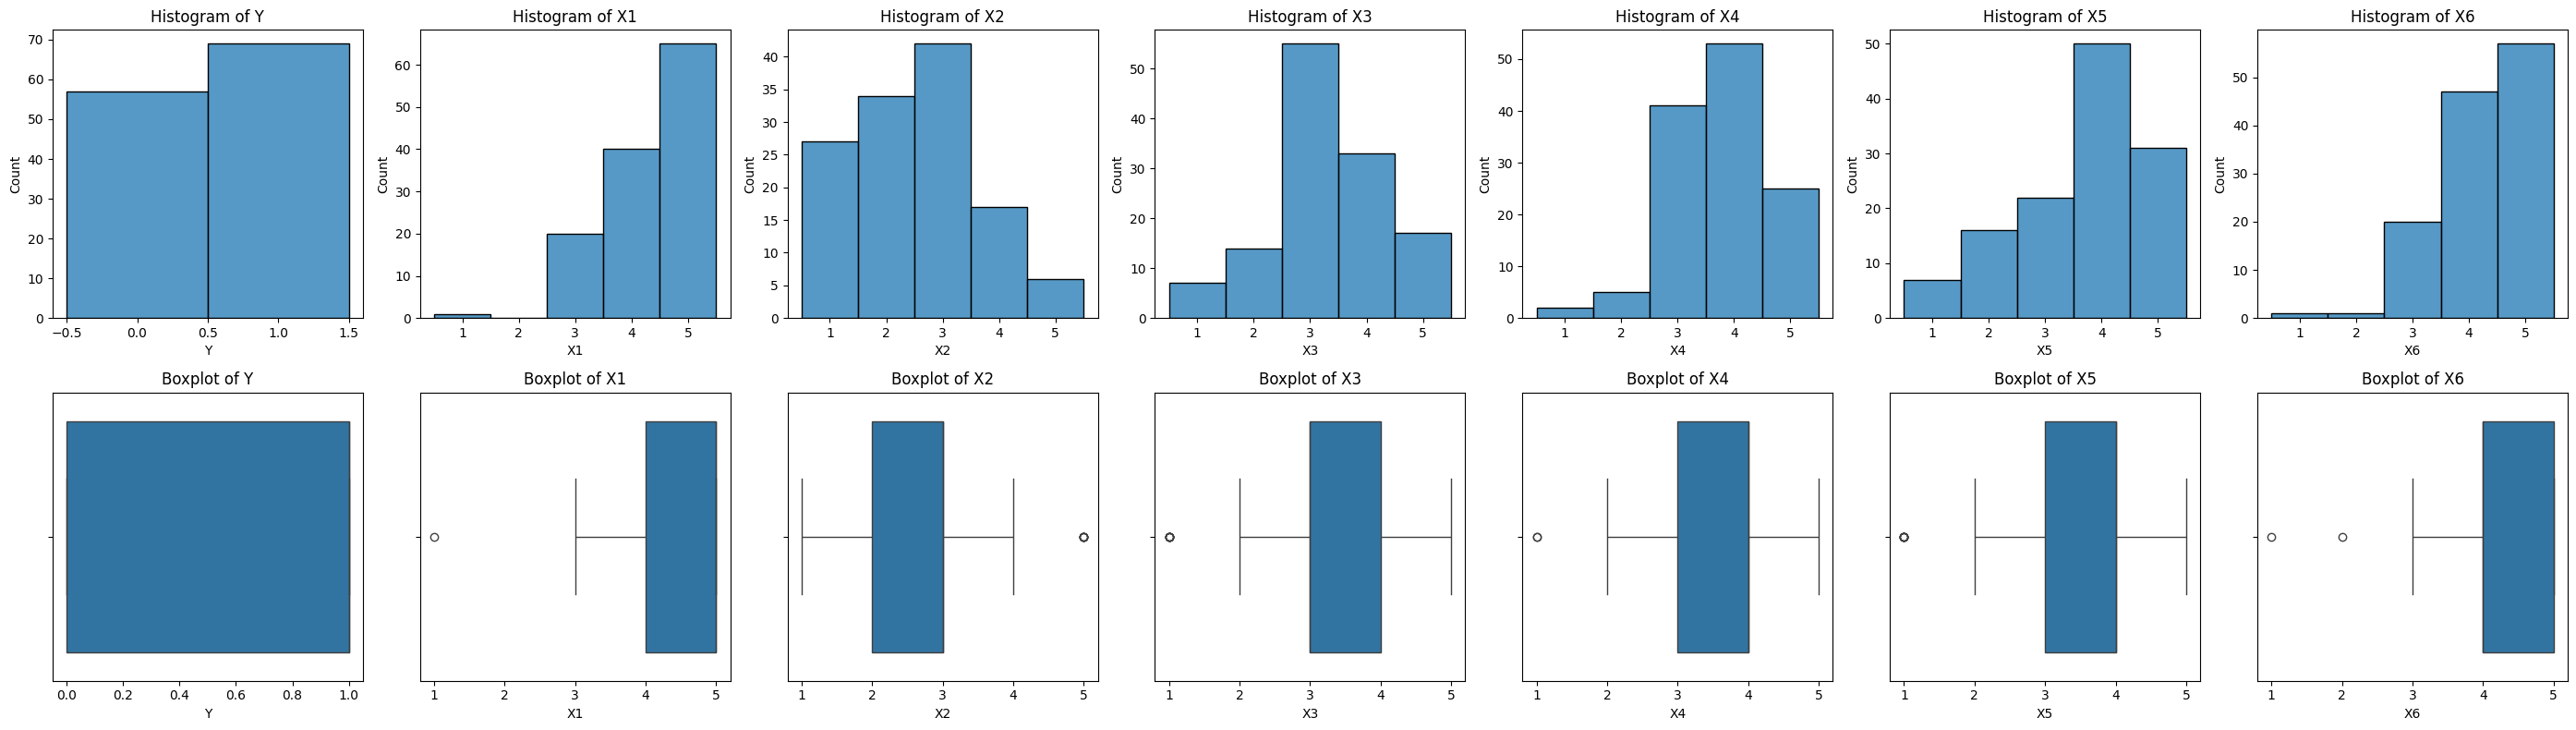

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Function to plot histograms and boxplots for each column
def plot_histograms_and_boxplots(df):
    num_columns = len(df.columns)

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(2, num_columns, figsize=(4*num_columns, 8))

    for i, column in enumerate(df.columns):
        # Histogram
        sns.histplot(df[column], discrete=True, ax=axes[0, i])
        axes[0, i].set_title(f'Histogram of {column}')

        # Boxplot
        sns.boxplot(x=df[column], ax=axes[1, i])
        axes[1, i].set_title(f'Boxplot of {column}')

    plt.tight_layout()
    plt.show()

plot_histograms_and_boxplots(data)

Per the Y histogram, almost half of the customers are unhappy. We want to know why these customers are happy, and what we can do to make them happy. Specifically, we want to know which questions help distinguish happy and unhappy customers.







## Unhappy Customers

In [6]:
unhappy_data = data[data['Y'] == 0]
unhappy_data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
6,0,3,1,2,2,1,3


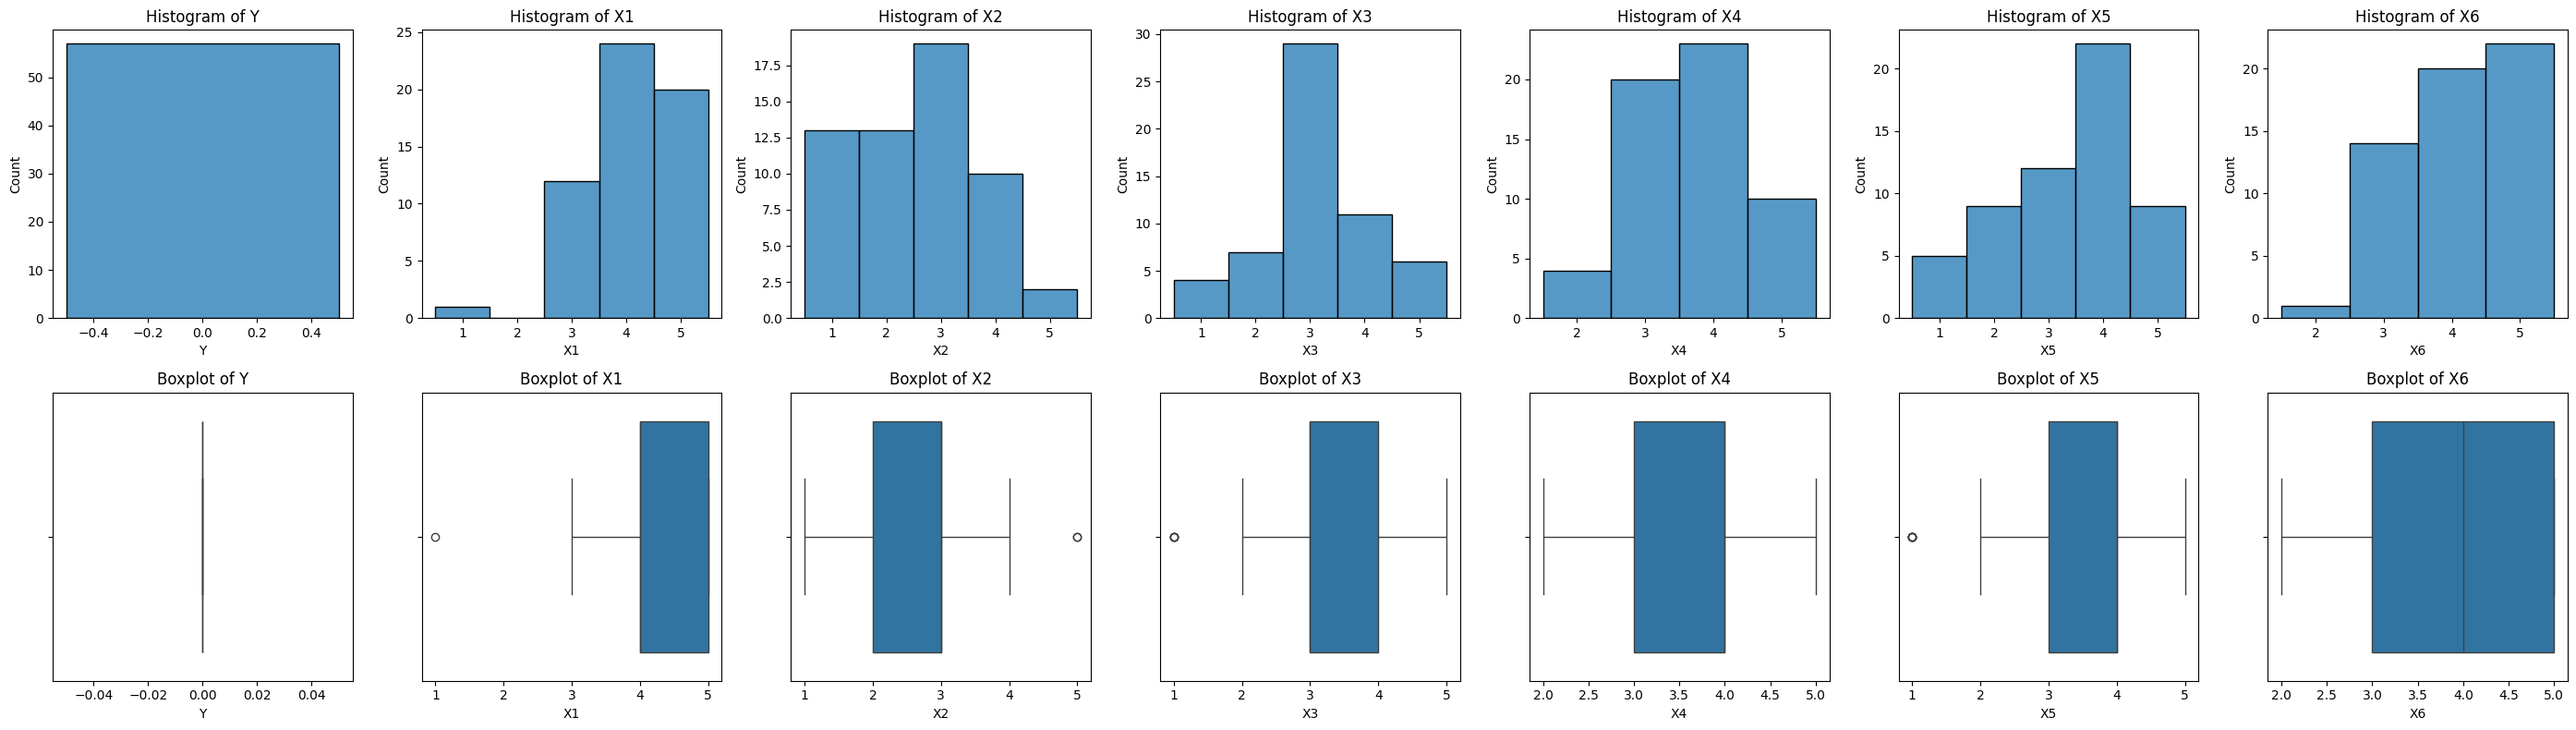

In [7]:
plot_histograms_and_boxplots(unhappy_data)

## Happy Customers

In [8]:
happy_data = data[data['Y'] == 1]
happy_data.head()

,Y,X1,X2,X3,X4,X5,X6
2,1,5,3,3,3,3,5
5,1,5,5,3,5,5,5
7,1,5,4,4,4,4,5
12,1,5,2,4,5,5,5
15,1,3,2,4,3,4,4


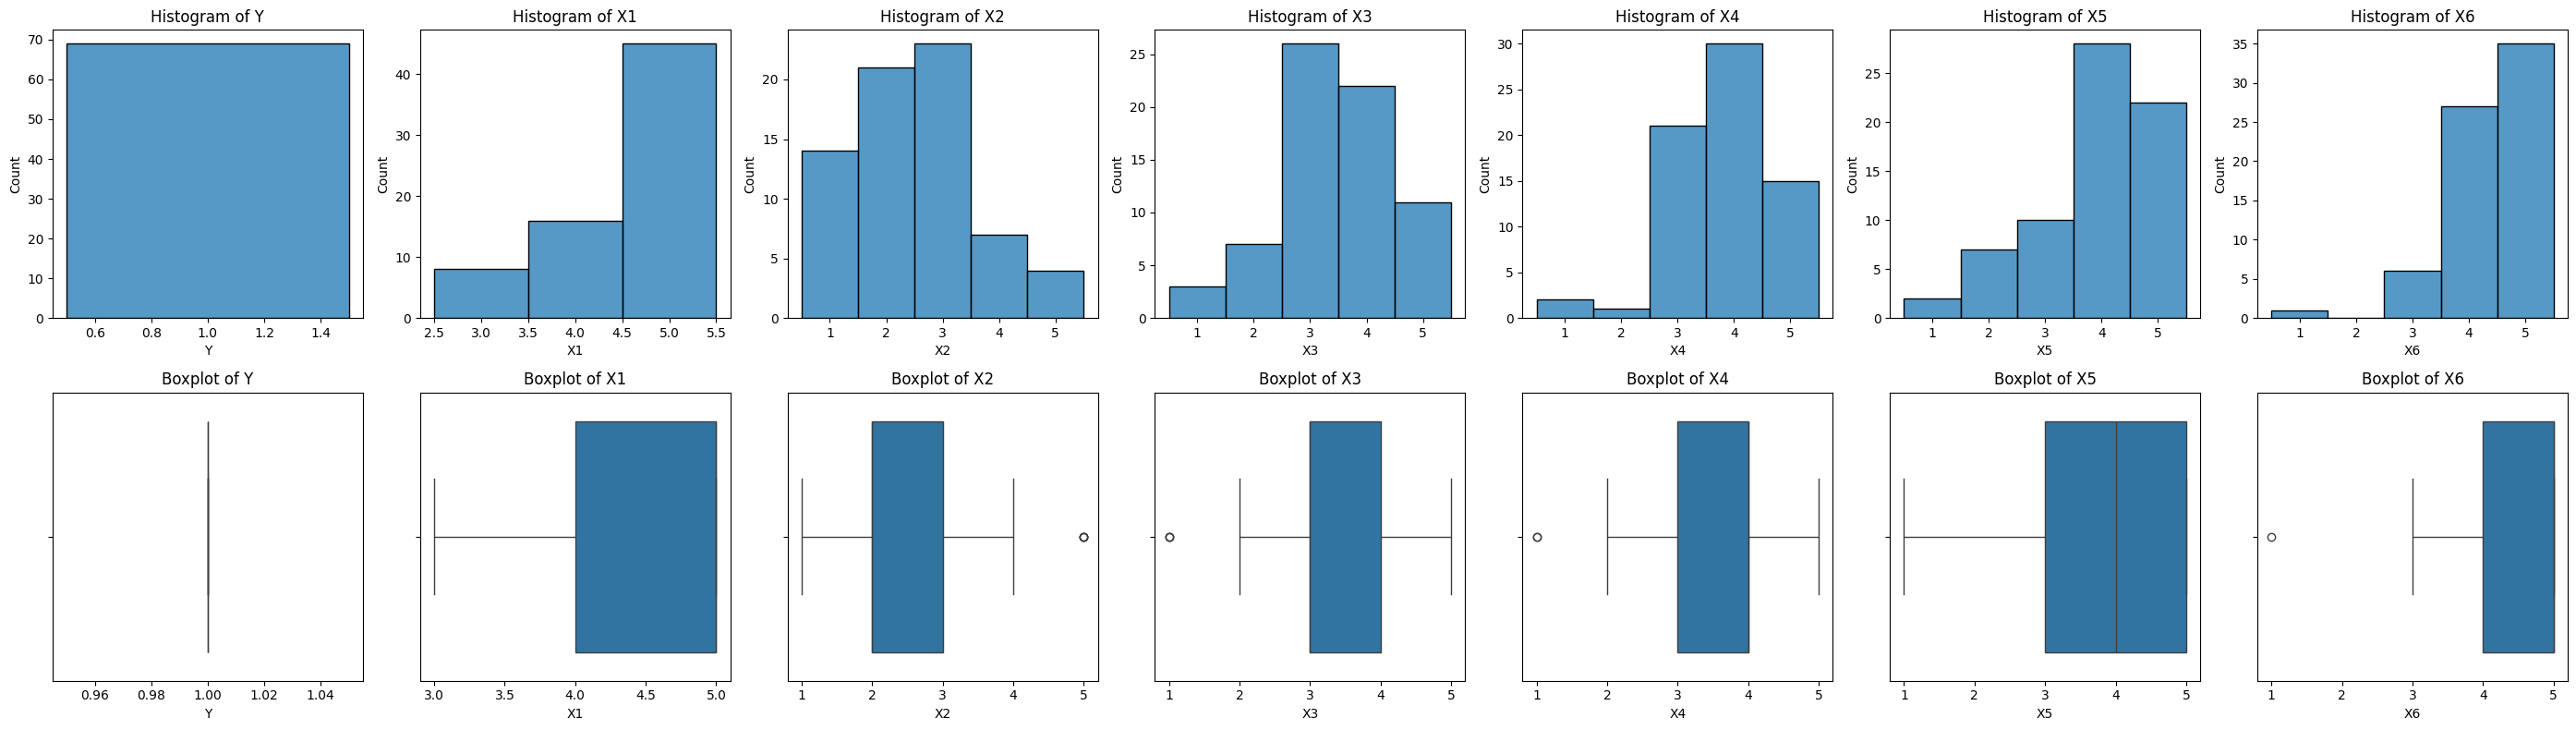

In [9]:
plot_histograms_and_boxplots(happy_data)

## Observations

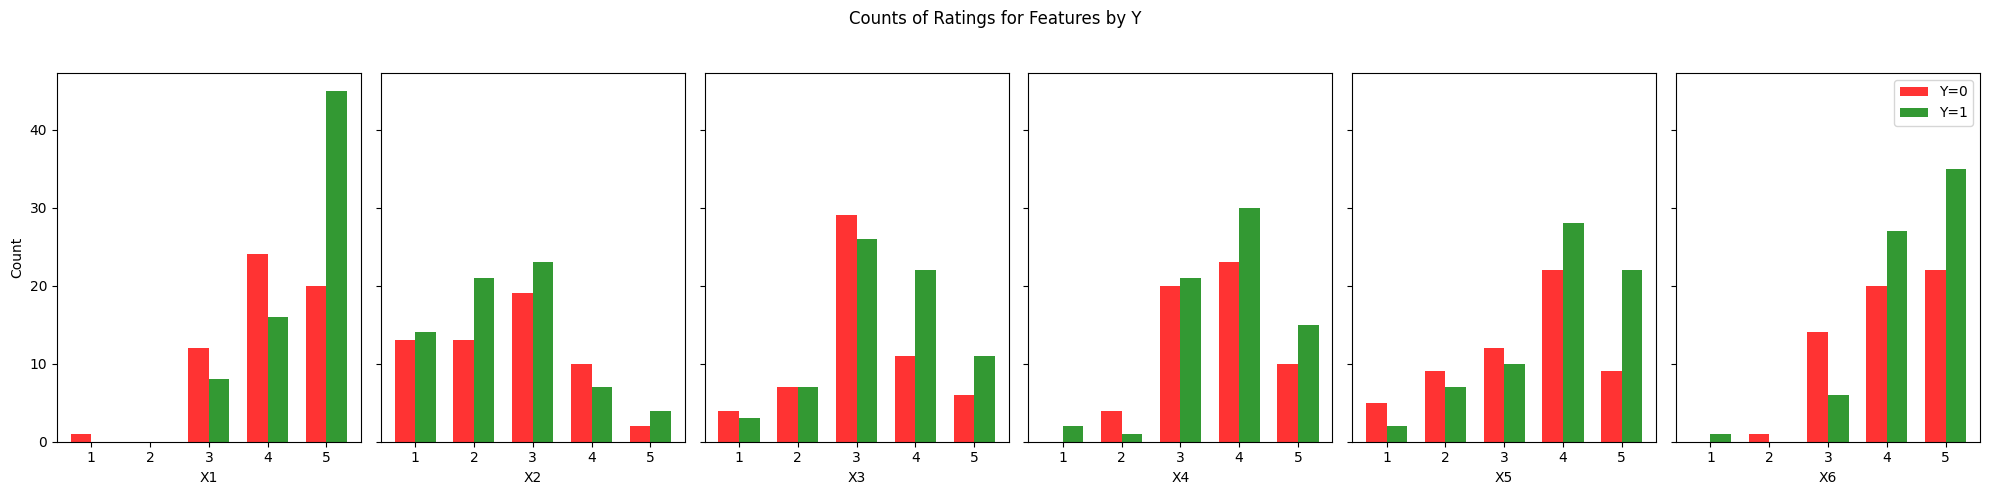

In [10]:
# Define the feature columns
feature_columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']

# Number of features
num_features = len(feature_columns)

# Create subplots
fig, axes = plt.subplots(1, num_features, figsize=(20, 5), sharey=True)

# Create a bar chart for each feature
for i, feature in enumerate(feature_columns):
    # Count the occurrences of each rating for Y=0 and Y=1
    counts_0 = unhappy_data[feature].value_counts().sort_index()
    counts_1 = happy_data[feature].value_counts().sort_index()

    # Ensure all ratings from 1 to 5 are included, even if their count is 0
    all_ratings = pd.Series([0, 0, 0, 0, 0], index=[1, 2, 3, 4, 5])
    counts_0 = all_ratings.add(counts_0, fill_value=0)
    counts_1 = all_ratings.add(counts_1, fill_value=0)

    # Create the bar chart
    index = counts_0.index
    bar_width = 0.35
    opacity = 0.8

    bars_0 = axes[i].bar(index - bar_width/2, counts_0, bar_width,
                         alpha=opacity, color='red', label='Y=0')
    bars_1 = axes[i].bar(index + bar_width/2, counts_1, bar_width,
                         alpha=opacity, color='green', label='Y=1')

    axes[i].set_xlabel(feature)
    axes[i].set_xticks(index)
    axes[i].set_xticklabels(index)
    if i == 0:
        axes[i].set_ylabel('Count')
    if i == num_features - 1:
        axes[i].legend()

fig.suptitle('Counts of Ratings for Features by Y')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()

*  X1: < 3: Unhappy. > 4: High likelihood happy
*  X2: No clear pattern.
*  X3: > 3: High likelihood Happy
*  X4: > 3: High likelihood Happy
*  X5: > 3: High likelihood Happy
*  X6: > 3: High likelihood Happy

X1 gives the most information distinguishing happy and unhappy customers. All ratings below 5 have significantly more unhappy customers, and the 5 rating has significantly more happy customers.

X2, X3 and X4 hardly give any information distinguishing happy and unhappy customers. There is not much of a margin between happy and unhappy customers for each of the ratings. 100% of 1 ratings for X4 are happy customers, but there are not enough respondents with that rating to give any significant amount of information.

X5 gives some better information, because there is a significant margin between happy and unhappy customers for the 5 rating, but not for the other ratings.

X6 is even better because there is significant margin between happy and happy customers for ratings 3 and 5.


In [11]:
X = data.drop('Y', axis=1)
y = data['Y']
X.head()

,X1,X2,X3,X4,X5,X6
0,3,3,3,4,2,4
1,3,2,3,5,4,3
2,5,3,3,3,3,5
3,5,4,3,3,3,5
4,5,4,3,3,3,5


# Models

## Basic Predictions

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Make the test set 1/9 of the data set because 126 is divisible by 9. Also set random_state to 42 (chosen arbitrarily) to ensure reproducability of train-test split.

Also, tune the models to prevent overfitting to the small amount of data we have.

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/9, shuffle=True, random_state=42)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=10),
    'Random Forest': RandomForestClassifier(min_samples_leaf=2, min_samples_split=10),
    'Extra Trees': ExtraTreesClassifier(min_samples_leaf=2, min_samples_split=10),
    'Gradient Boosting': GradientBoostingClassifier(min_samples_leaf=2, min_samples_split=10),
    'SVC': SVC(kernel='poly', degree=2)
}

Metrics:



*   Accuracy: How well does model predictions match test data.
*   Precision: How well does model predict positive.
*   Recall: How well does capture positive labels.





Metric Importance:



*   Accuracy: Incorrect positive and negative predictions are dangerous.
*   Precision: Incorrect positive predictions are dangerous.
*   Recall: Incorrect negative predictions are dangerous.

We want customers to be happy, and almost half of the customers right now are unhappy. False happy predictions are dangerous. **Prioritize precision over accuracy over recall**, because incorrect negative predictions are merely an inconvenience. High precision can mean low recall, but as stated, falsely predicting customers as unhappy is not dangerous. Therefore, there is no need to look at the recall metric.


In [14]:
from sklearn.metrics import precision_score, accuracy_score

for model in models:
    models[model].fit(X_train, y_train)
    y_pred = models[model].predict(X_test)

    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{model}: {precision:.2f}, {accuracy:.2f}")

Logistic Regression: 0.45, 0.43
KNeighborsClassifier: 0.56, 0.57
Decision Tree: 0.55, 0.57
Random Forest: 0.56, 0.57
Extra Trees: 0.60, 0.64
Gradient Boosting: 0.67, 0.71
SVC: 0.56, 0.57


Gradient Boosting is giving 71% precision. Not only it's not high enough, but it's not enough information to conclude it's a good model because the train-test split is random.

## Standardize Data

All features are already on the same scale (1-5), but it's good practice to standardize, especially when features are not on the same scale.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [16]:
for model in models:
    pipeline = Pipeline([
      ('scaler', scaler),
      ('classifier', models[model])
    ])

    models[model].fit(X_train, y_train)
    y_pred = models[model].predict(X_test)

    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{model}: {precision:.2f}, {accuracy:.2f}")

Logistic Regression: 0.45, 0.43
KNeighborsClassifier: 0.56, 0.57
Decision Tree: 0.55, 0.57
Random Forest: 0.56, 0.57
Extra Trees: 0.56, 0.57
Gradient Boosting: 0.67, 0.71
SVC: 0.56, 0.57


As expected, standardizing does not change the results, as the features were on the same scale to begin with.

## Cross Validation

We can use 9 fold cross validation to make sure that gradient boosting precision is good across several train test splits. 9 fold cross validation is good not only because 126 is divisible by 9, but also because it will reduce bias (each model is trained on a larger portion of data) and variance (model is less dependent on a particular split).

The only downside to 9 fold cross validation is a higher computational cost, but it doesn't matter here because there are only 126 observations to begin with.

Like in a normal train-test split, we set random_state to 42 (chosen arbitrarily) to ensure the reproducibility of the train-test splits.

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

kfold = KFold(n_splits=9, shuffle=True, random_state=42)

scoring = {
    'precision': make_scorer(precision_score, average='macro'),
    'accuracy': 'accuracy'
}

In [18]:
from sklearn.model_selection import cross_validate

results_dict = {
    'Model': [],
    'Median Accuracy': [],
    'Std Accuracy': [],
    'Median Precision': [],
    'Std Precision': []
}

for model in models:
    pipeline = Pipeline([
      ('scaler', scaler),
      ('classifier', models[model])
    ])

    results = cross_validate(pipeline, X, y, cv=kfold, scoring=scoring)
    # Append the results to the dictionary
    results_dict['Model'].append(model)
    results_dict['Median Accuracy'].append(np.median(results['test_accuracy']))
    results_dict['Std Accuracy'].append(np.std(results['test_accuracy']))
    results_dict['Median Precision'].append(np.median(results['test_precision']))
    results_dict['Std Precision'].append(np.std(results['test_precision']))

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)
results_df

,Model,Median Accuracy,Std Accuracy,Median Precision,Std Precision
0,Logistic Regression,0.571429,0.106479,0.583333,0.129445
1,KNeighborsClassifier,0.500000,0.101015,0.500000,0.132437
2,Decision Tree,0.571429,0.111677,0.625000,0.121536
3,Random Forest,0.571429,0.078567,0.577778,0.092795
4,Extra Trees,0.571429,0.075292,0.577778,0.084627
5,Gradient Boosting,0.571429,0.121405,0.583333,0.142550
6,SVC,0.571429,0.089087,0.583333,0.149533


None of the models are giving a good precision score with cross validation. We know that not all questions distingush happy and unhappy customers well. Let's use questions X1 and X6, as they give the most information.

In [19]:
from sklearn.model_selection import cross_validate

results_dict = {
    'Model': [],
    'Median Accuracy': [],
    'Std Accuracy': [],
    'Median Precision': [],
    'Std Precision': []
}

for model in models:
    pipeline = Pipeline([
      ('scaler', scaler),
      ('classifier', models[model])
    ])

    results = cross_validate(pipeline, X[['X1', 'X6']], y, cv=kfold, scoring=scoring)
    # Append the results to the dictionary
    results_dict['Model'].append(model)
    results_dict['Median Accuracy'].append(np.median(results['test_accuracy']))
    results_dict['Std Accuracy'].append(np.std(results['test_accuracy']))
    results_dict['Median Precision'].append(np.median(results['test_precision']))
    results_dict['Std Precision'].append(np.std(results['test_precision']))

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)
results_df

,Model,Median Accuracy,Std Accuracy,Median Precision,Std Precision
0,Logistic Regression,0.571429,0.101015,0.583333,0.088704
1,KNeighborsClassifier,0.571429,0.093906,0.625000,0.089460
2,Decision Tree,0.642857,0.095897,0.645833,0.118192
3,Random Forest,0.642857,0.093906,0.675000,0.133454
4,Extra Trees,0.642857,0.124984,0.696970,0.195508
5,Gradient Boosting,0.642857,0.093906,0.675000,0.133454
6,SVC,0.500000,0.110543,0.730769,0.232405


The only model that has a precision at or above 73% is the Support Vector Classifier. But it's not a good result because the standard deviation is too high (23%). This is likely occuring because we chose a bad random number seed for the KFold cross validation. Let's see if changing the random seed improves results.

In [20]:
kfold = KFold(n_splits=9, shuffle=True, random_state=123)

results_dict = {
    'Model': [],
    'Median Accuracy': [],
    'Std Accuracy': [],
    'Median Precision': [],
    'Std Precision': []
}

for model in models:
    pipeline = Pipeline([
      ('scaler', scaler),
      ('classifier', models[model])
    ])

    results = cross_validate(pipeline, X[['X1', 'X6']], y, cv=kfold, scoring=scoring)
    # Append the results to the dictionary
    results_dict['Model'].append(model)
    results_dict['Median Accuracy'].append(np.median(results['test_accuracy']))
    results_dict['Std Accuracy'].append(np.std(results['test_accuracy']))
    results_dict['Median Precision'].append(np.median(results['test_precision']))
    results_dict['Std Precision'].append(np.std(results['test_precision']))

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)
results_df

,Model,Median Accuracy,Std Accuracy,Median Precision,Std Precision
0,Logistic Regression,0.642857,0.139285,0.722222,0.148422
1,KNeighborsClassifier,0.714286,0.129441,0.714286,0.141599
2,Decision Tree,0.714286,0.125988,0.725000,0.140407
3,Random Forest,0.714286,0.149746,0.800000,0.153660
4,Extra Trees,0.714286,0.135154,0.750000,0.138923
5,Gradient Boosting,0.714286,0.139285,0.750000,0.141636
6,SVC,0.642857,0.130410,0.416667,0.208288


The results are indeed better. Let's try 10 randomly selected unique numbers and run the models with each of those random seeds.

In [21]:
from random import sample
seeds = sample(range(1,100), 10)

In [22]:
dfs = []
for seed in seeds:
  kfold = KFold(n_splits=9, shuffle=True, random_state=75)

  results_dict = {
      'Model': [],
      'Median Accuracy': [],
      'Std Accuracy': [],
      'Median Precision': [],
      'Std Precision': []
  }

  for model in models:
      pipeline = Pipeline([
        ('scaler', scaler),
        ('classifier', models[model])
      ])

      results = cross_validate(pipeline, X[['X1', 'X6']], y, cv=kfold, scoring=scoring)
      # Append the results to the dictionary
      results_dict['Model'].append(model)
      results_dict['Median Accuracy'].append(np.median(results['test_accuracy']))
      results_dict['Std Accuracy'].append(np.std(results['test_accuracy']))
      results_dict['Median Precision'].append(np.median(results['test_precision']))
      results_dict['Std Precision'].append(np.std(results['test_precision']))

  # Convert the results dictionary to a DataFrame
  dfs.append(pd.DataFrame(results_dict))

In [23]:
from IPython.display import display_html

def display_side_by_side(dfs, titles=[]):
    html_str = ''
    for df, title in zip(dfs, titles):
        html_str += f'<div style="display:inline-block; margin-right: 20px;">'
        html_str += f'<h3>{title}</h3>'
        html_str += df.to_html()
        html_str += '</div>'
    display_html(html_str, raw=True)

# Display DataFrames side by side with seeds as titles
display_side_by_side(dfs, seeds)

,Model,Median Accuracy,Std Accuracy,Median Precision,Std Precision
0,Logistic Regression,0.642857,0.083239,0.727273,0.114261
1,KNeighborsClassifier,0.714286,0.133748,0.651515,0.200510
2,Decision Tree,0.642857,0.093906,0.750000,0.141128
3,Random Forest,0.642857,0.099760,0.791667,0.145542
4,Extra Trees,0.714286,0.101637,0.791667,0.119363
5,Gradient Boosting,0.642857,0.070986,0.772727,0.130513
6,SVC,0.571429,0.111677,0.708333,0.245892
,Model,Median Accuracy,Std Accuracy,Median Precision,Std Precision
0,Logistic Regression,0.642857,0.083239,0.727273,0.114261
1,KNeighborsClassifier,0.714286,0.133748,0.651515,0.200510


All of the 10 seeds chosen are performing well. This confirms that the models are highly sensitive to a particular random seed, which in turn means a particular set of folds. If we had access to more compute power, we can try even more seeds to increase our confidence in the results.

Ideally, models should not be sensitive to a particular seed. However, it is expected in this case because we don't have much data. To improve the reliability of our results, we need more data.

# Results

For the purposes of this project, let's use the results when the seed was 57.

Decision Tree, Random Forest, Extra Trees, and Gradient Boosting are performing very well, with precisions >= 73%. These mean that least 73% of the predictions correctly predict a happy customer. These are the results for 1 standard devation (assuming scores are normally distributed) for precision and accuracy:

Decision Tree: DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=10):

*   0.75 +- 0.14 for precision
*   0.64 +- 0.09 for accuracy

RandomForest: RandomForestClassifier(min_samples_leaf=2, min_samples_split=10):

*   0.81 +- 0.14 for precision
*   0.71 +- 0.10 for accuracy

Extra Trees: ExtraTreesClassifier(min_samples_leaf=2, min_samples_split=10)


*   0.79 +- 0.11 for precision
*   0.71 +- 0.10 for accuracy


Gradient Boosting: GradientBoostingClassifier(min_samples_leaf=2, min_samples_split=10)


*   0.77 +- 0.13 for precision
*   0.64 +- 0.07 for accuracy



A 1 standard deviation range gives 68% confidence that the metrics fall in these ranges.


Clearly, RandomForest is the winning model. We are 68% confident that the precision falls with [0.67, 0.95], and accuracy falls within [0.61, 0.81].


# Conclusion

The goal of the project is to figure out which survey questions to focus on to make customers happy. We tried several models with a train-test split that would reduce bias and variance. We are aiming for a high precision score because it's important that we don't falsely classify customers as happy. Although falsely classifying happy customers as unhappy is not great, doing so is not as harmful to the business.

We also tuned the models accordingly so they don't overfit to the small amount of data we have.

The conclusion is that the RandomForestClassifier(min_samples_leaf=2, min_samples_split=10) because it has the highest median precision and accuracy scores with reasonable standard devations. The 68% confidence interval of [0.67,0.95] for precison and [0.61,0.71] for accuracy gives us good confidence that the model will classify happy customers well.

The best questions are X1 and X6, as they give the most information about whether a customer is happy or not.

X1: My order was delivered on time.

X6: The app makes ordering easy for me.

The next step is to shorten the survey to these two questions and send it out to more customers. That way, we will get more data and confirm that these two questions are indeed what the company needs to focus on to make their customers happy. More data will allow us to better validate the RandomForest model.